In [1]:
import pandas as pd
import numpy as np
import os

# Perimeter

In [4]:
data = pd.read_parquet("../data/edited_data/modeling/data")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 669916 entries, tt0000038 to tt9916764
Data columns (total 10 columns):
averageRating_actors       338606 non-null float64
averageRating_directors    147198 non-null float64
averageRating_genres       652487 non-null float64
ProductionBudget           4014 non-null float64
primaryTitle               669562 non-null object
nLetters                   669562 non-null float64
nCapitalLetters            669562 non-null float64
nWords                     669562 non-null float64
averageRating              277451 non-null float64
numVotes                   277451 non-null float64
dtypes: float64(9), object(1)
memory usage: 56.2+ MB


In [6]:
data = data.drop(columns=["numVotes"], axis=1)

In [163]:
perimeter = data.drop(columns=["ProductionBudget", "primaryTitle"], axis=1).dropna()
~#perimeter = data.drop(columns=["primaryTitle"], axis=1).dropna()

La feature "productionBudget" ne permet d'affiner le modèle - en plus de présenter un faible taux de remplissage

### Exploratory analysis

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

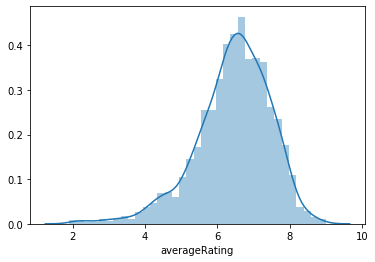

In [165]:
sns.distplot(perimeter.averageRating)

#### correlations

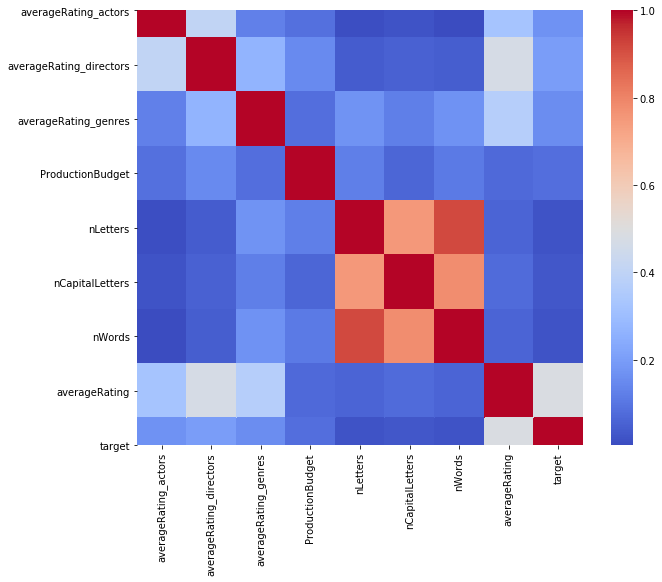

In [166]:
corr = np.abs(data.corr())

fig = plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm")

nLetters & nWords sont trop corrélés à la variable nCapitalLetters

In [167]:
perimeter = perimeter.drop(columns=["nLetters", "nWords"], axis=1)

## modeling

### Linear model

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [169]:
X = perimeter.drop(columns=["averageRating", "target"], axis=1)
y = perimeter.averageRating

In [170]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2080 entries, tt0016641 to tt9024106
Data columns (total 5 columns):
averageRating_actors       2080 non-null float64
averageRating_directors    2080 non-null float64
averageRating_genres       2080 non-null float64
ProductionBudget           2080 non-null float64
nCapitalLetters            2080 non-null float64
dtypes: float64(5)
memory usage: 97.5+ KB


In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12345)

In [172]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

In [173]:
from sklearn.linear_model import LinearRegression

In [174]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [175]:
lr.score(X_test_scaled, y_test)

0.20081009678308456

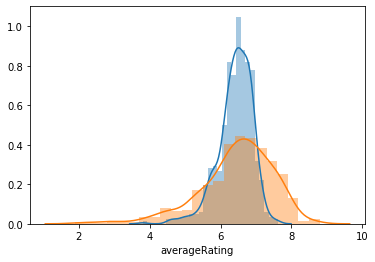

In [176]:
sns.distplot(lr.predict(X_test_scaled))
sns.distplot(y_test)

Tendance à prédire la moyenne...

### Classifier

#### preprocess

In [177]:
m = perimeter.averageRating.mean()
sigma = perimeter.averageRating.std()

def get_rate_classes(rate):
    if rate < m - sigma:
        return 0
    if rate < m:
        return 1
    if rate < m + sigma:
        return 2
    else:
        return 3
    
print(m-sigma, m, m+sigma)


perimeter["target"] = perimeter.averageRating.apply(get_rate_classes)

5.398407316650252 6.434951923076925 7.4714965295035976


In [178]:
X = perimeter.drop(columns=["averageRating", "target"], axis=1)
y = perimeter.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12345)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

#### modeling

In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [180]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.15      0.24        85
           1       0.39      0.40      0.39       191
           2       0.45      0.74      0.56       246
           3       1.00      0.01      0.02       102

    accuracy                           0.44       624
   macro avg       0.59      0.33      0.30       624
weighted avg       0.53      0.44      0.38       624



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [181]:
clf = RandomForestClassifier()
param_grid = {
    'max_depth': [10],
    'n_estimators': [100]
}

grid = GridSearchCV(estimator=clf, param_grid=param_grid, verbose=2)

grid.fit(X_train_scaled, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   0.1s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   0.1s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [182]:
y_pred = grid.predict(X_test_scaled)

In [183]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.20      0.27        85
           1       0.43      0.50      0.47       191
           2       0.50      0.68      0.57       246
           3       0.35      0.09      0.14       102

    accuracy                           0.46       624
   macro avg       0.43      0.37      0.36       624
weighted avg       0.44      0.46      0.43       624



In [194]:
contributions = dict(zip(X_train.columns.tolist(), grid.best_estimator_.feature_importances_))
pd.DataFrame.from_dict(contributions, orient="index").sort_values(by=0, ascending=False)

,0
averageRating_directors,0.262605
averageRating_actors,0.250815
averageRating_genres,0.210668
ProductionBudget,0.201657
nCapitalLetters,0.074256
